Passo 1 – Visualização inicial e diagnóstico dos dados


--- Informações gerais ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Orcamento_Total          100 non-null    float64
 1   Salario_Medio_Func       100 non-null    float64
 2   Numero_Fiscalizacoes     100 non-null    int64  
 3   Contratos_Publicos       100 non-null    int64  
 4   Indice_Transparencia     100 non-null    float64
 5   Partido_Governo          79 non-null     object 
 6   Midia_Livre              80 non-null     object 
 7   Judiciario_Atuante       94 non-null     object 
 8   Cultura_Corrupcao        73 non-null     object 
 9   Investigacoes_Federais   68 non-null     object 
 10  Corrupcao_Valor_Perdido  95 non-null     float64
dtypes: float64(4), int64(2), object(5)
memory usage: 8.7+ KB
None

--- Amostra do dataset ---
   Orcamento_Total  Salario_Medio_Func  Numero_Fiscalizacoes  \
0      

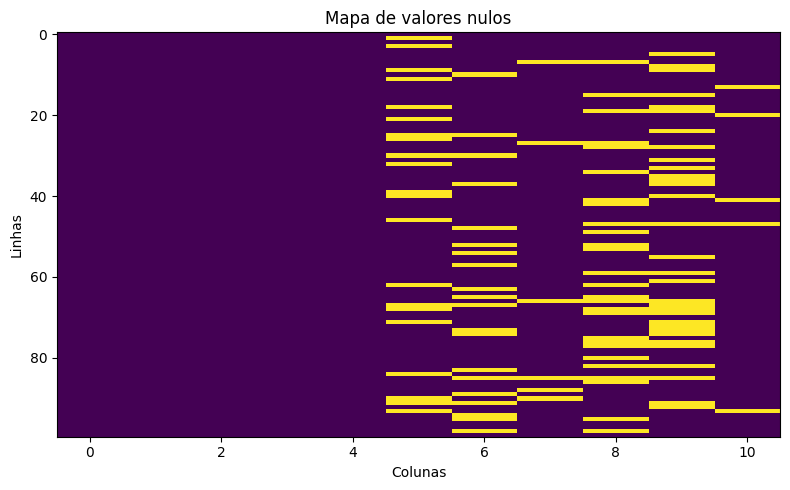

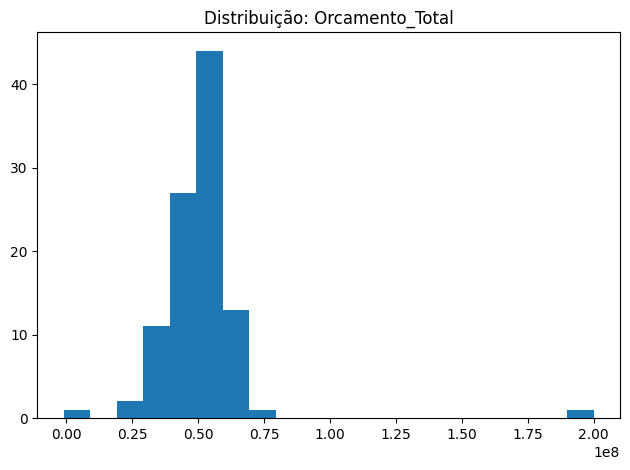

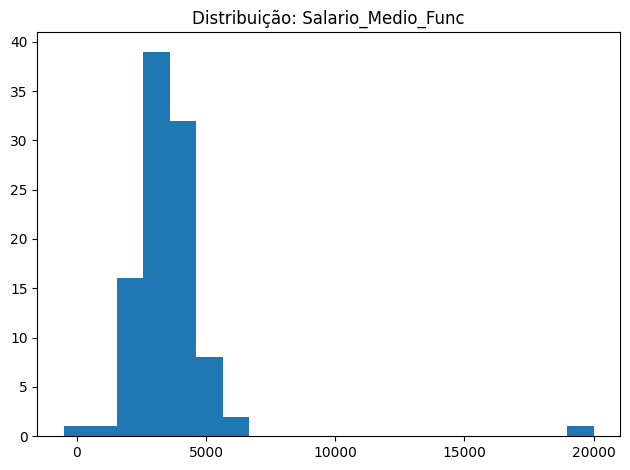

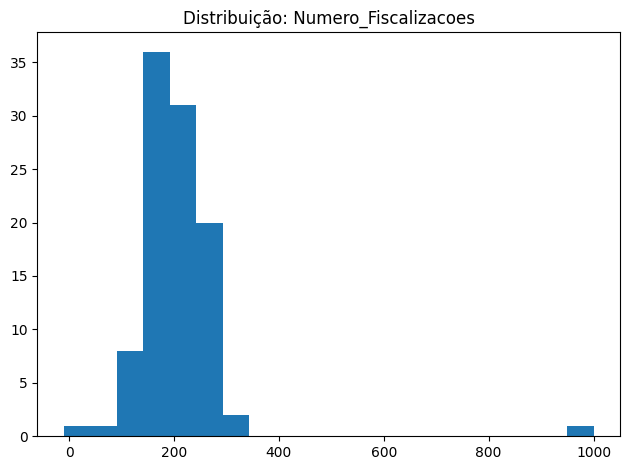

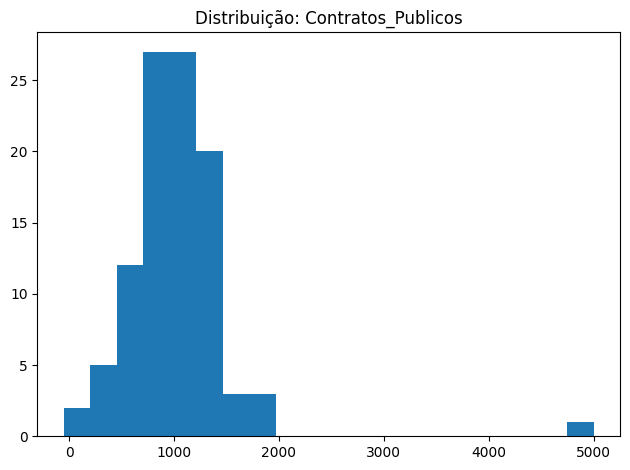

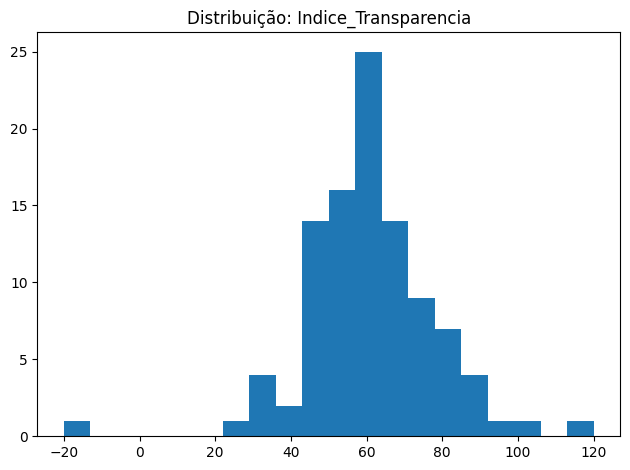

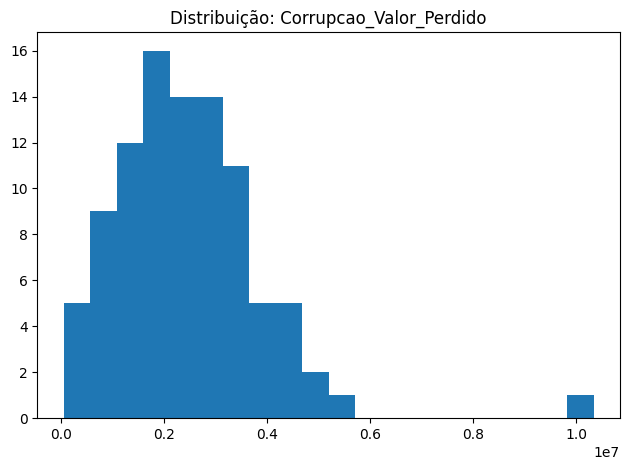

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Carregar dataset
df = pd.read_csv("/content/corrupcao.csv", sep=None, engine="python")

# 1. Estrutura da base
print("\n--- Informações gerais ---")
print(df.info())

# 2. Primeiras linhas
print("\n--- Amostra do dataset ---")
print(df.head())

# 5. Contagem de valores únicos (pra detectar inconsistências)
print("\n--- Valores únicos por coluna ---")
print(df.nunique())

# 6. Heatmap de nulos (matplotlib)
plt.figure(figsize=(8,5))
plt.imshow(df.isnull(), aspect='auto')
plt.title("Mapa de valores nulos")
plt.xlabel("Colunas")
plt.ylabel("Linhas")
plt.tight_layout()
plt.show()

# 7. Histograma das variáveis numéricas (para ver outliers)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
if num_cols:
    for c in num_cols:
        plt.figure()
        plt.hist(df[c].dropna(), bins=20)
        plt.title(f"Distribuição: {c}")
        plt.tight_layout()
        plt.show()


Tratamento de valores negativos e nulos

In [2]:
# Copiar base original
df_ready = df.copy()

# Variáveis numéricas que não podem ser negativas (ajustadas ao dataset de corrupção)
numeric_cols = [
    "Orcamento_Total",
    "Salario_Medio_Func",
    "Numero_Fiscalizacoes",
    "Contratos_Publicos",
    "Indice_Transparencia",
    "Corrupcao_Valor_Perdido",
]

# 1. Substituir valores negativos por NaN
for col in numeric_cols:
    if col in df_ready.columns:
        neg_count = (df_ready[col] < 0).sum()
        if neg_count > 0:
            df_ready.loc[df_ready[col] < 0, col] = np.nan
            print(f"{col}: {neg_count} valores negativos -> NaN")

# 2. Preencher numéricos com mediana
for col in numeric_cols:
    if col in df_ready.columns:
        if df_ready[col].isnull().sum() > 0:
            med = df_ready[col].median()
            df_ready[col].fillna(med, inplace=True)
            print(f"{col}: nulos preenchidos com mediana ({med})")

# 3. Tratar variáveis categóricas → preencher NaN com moda
for col in df_ready.select_dtypes(include=["object"]).columns:
    if df_ready[col].isnull().sum() > 0:
        moda = df_ready[col].mode()[0]
        df_ready[col].fillna(moda, inplace=True)
        print(f"{col}: nulos preenchidos com moda ('{moda}')")

# 4. Conferência final
print("\n--- Valores nulos após limpeza ---")
print(df_ready.isnull().sum())

# 5. Estatísticas pós-tratamento
print("\n--- Estatísticas atualizadas ---")
print(df_ready.describe(include="all"))


Orcamento_Total: 1 valores negativos -> NaN
Salario_Medio_Func: 1 valores negativos -> NaN
Numero_Fiscalizacoes: 1 valores negativos -> NaN
Contratos_Publicos: 1 valores negativos -> NaN
Indice_Transparencia: 1 valores negativos -> NaN
Orcamento_Total: nulos preenchidos com mediana (50895775.0)
Salario_Medio_Func: nulos preenchidos com mediana (3507.0)
Numero_Fiscalizacoes: nulos preenchidos com mediana (201.0)
Contratos_Publicos: nulos preenchidos com mediana (1021.0)
Indice_Transparencia: nulos preenchidos com mediana (59.3)
Corrupcao_Valor_Perdido: nulos preenchidos com mediana (2294293.0)
Partido_Governo: nulos preenchidos com moda ('Conservador')
Midia_Livre: nulos preenchidos com moda ('Média')
Judiciario_Atuante: nulos preenchidos com moda ('Sim')
Cultura_Corrupcao: nulos preenchidos com moda ('Média')
Investigacoes_Federais: nulos preenchidos com moda ('Sim')

--- Valores nulos após limpeza ---
Orcamento_Total            0
Salario_Medio_Func         0
Numero_Fiscalizacoes      

/tmp/ipython-input-2711768293.py:27: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_ready[col].fillna(med, inplace=True)
/tmp/ipython-input-2711768293.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df

Começar regressão

In [3]:
from sklearn.model_selection import train_test_split

# 1. Transformar categóricas em dummies
df_model = pd.get_dummies(df_ready, drop_first=True)

# 2. Garantir que tudo é numérico
df_model = df_model.astype(float)

# 3. Definir X e y (alvo: Corrupcao_Valor_Perdido)
target_col = "Corrupcao_Valor_Perdido"
assert target_col in df_model.columns, "Coluna alvo não encontrada no dataset."
X = df_model.drop(target_col, axis=1)
y = df_model[target_col]

# 4. Divisão treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("\n--- Shapes dos conjuntos ---")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

print("\nDataset pronto para regressão ✅")



--- Shapes dos conjuntos ---
X_train: (70, 14)
X_test : (30, 14)
y_train: (70,)
y_test : (30,)

Dataset pronto para regressão ✅


In [4]:
import statsmodels.api as sm
from sklearn.metrics import r2_score
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy import stats

# 1. Adicionar constante
X_train_const = sm.add_constant(X_train)
X_test_const  = sm.add_constant(X_test)

# 2. Ajustar modelo linear
model_lin = sm.OLS(y_train, X_train_const).fit()

# 3. Predições
y_pred_train = model_lin.predict(X_train_const)
y_pred_test  = model_lin.predict(X_test_const)

# 4. R²
r2_tr = r2_score(y_train, y_pred_train)
r2_te = r2_score(y_test, y_pred_test)

# 5. Testes de resíduos
residuos = y_train - y_pred_train
lm_stat, lm_p, fval, f_p = het_breuschpagan(residuos, X_train_const)
bp_status = "HOMOCEDÁSTICO" if lm_p > 0.05 else "HETEROCEDÁSTICO"
dw = durbin_watson(residuos)
dw_status = "Sem autocorrelação forte" if 1.5 <= dw <= 2.5 else "Possível autocorrelação"

# Shapiro-Wilk (normalidade)
sh_stat, sh_p = stats.shapiro(residuos)
sh_status = "Normal" if sh_p > 0.05 else "NÃO normal"

# 7. Resultados
print("=== Regressão Linear - Resultados ===")
print(f"R² treino: {r2_tr:.4f}")
print(f"R² teste : {r2_te:.4f}")
print(f"Breusch-Pagan: p={lm_p:.4f} → {bp_status}")
print(f"Durbin-Watson: {dw:.2f} → {dw_status}")
print(f"Shapiro-Wilk: p={sh_p:.4f} → Resíduos {sh_status}")

# 8. Tabelinha completa com p-valores e R² ajustado
print("\n--- Resumo do modelo ---")
print(model_lin.summary())


=== Regressão Linear - Resultados ===
R² treino: 0.5925
R² teste : -0.2808
Breusch-Pagan: p=0.8908 → HOMOCEDÁSTICO
Durbin-Watson: 1.71 → Sem autocorrelação forte
Shapiro-Wilk: p=0.9572 → Resíduos Normal

--- Resumo do modelo ---
                               OLS Regression Results                              
Dep. Variable:     Corrupcao_Valor_Perdido   R-squared:                       0.592
Model:                                 OLS   Adj. R-squared:                  0.489
Method:                      Least Squares   F-statistic:                     5.712
Date:                     Tue, 02 Sep 2025   Prob (F-statistic):           1.17e-06
Time:                             02:36:41   Log-Likelihood:                -1060.4
No. Observations:                       70   AIC:                             2151.
Df Residuals:                           55   BIC:                             2185.
Df Model:                               14                                         
Covariance Type

Polinomial para ver se melhora os P valores

In [5]:
from sklearn.preprocessing import PolynomialFeatures

# 1. Gerar features polinomiais (grau 2)
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# 2. Split treino/teste
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(
    X_poly, y, test_size=0.3, random_state=42
)

# 3. Adicionar constante
X_train_p_const = sm.add_constant(X_train_p)
X_test_p_const  = sm.add_constant(X_test_p)

# 4. Ajustar modelo polinomial
model_poly = sm.OLS(y_train_p, X_train_p_const).fit()

# 5. Predições
y_pred_train_p = model_poly.predict(X_train_p_const)
y_pred_test_p  = model_poly.predict(X_test_p_const)

# 6. R²
r2_tr_p = r2_score(y_train_p, y_pred_train_p)
r2_te_p = r2_score(y_test_p, y_pred_test_p)

# 7. Testes de resíduos
residuos_p = y_train_p - y_pred_train_p
lm_stat2, lm_pvalue2, fval2, f_pvalue2 = het_breuschpagan(residuos_p, X_train_p_const)
bp_status_p = "HOMOCEDÁSTICO" if lm_pvalue2 > 0.05 else "HETEROCEDÁSTICO"
dw_p = durbin_watson(residuos_p)

# Shapiro-Wilk
sh_stat_p, sh_pvalue_p = stats.shapiro(residuos_p)
sh_status_p = "Normal" if sh_pvalue_p > 0.05 else "NÃO normal"

# 9. Resultados
print("=== Regressão Polinomial Grau 2 - Resultados ===")
print(f"R² treino: {r2_tr_p:.4f}")
print(f"R² teste : {r2_te_p:.4f}")
print(f"Breusch-Pagan: p={lm_pvalue2:.4f} → {bp_status_p}")
dw_status_p = 'Sem autocorrelação forte' if 1.5 <= dw_p <= 2.5 else 'Possível autocorrelação'
print(f"Durbin-Watson: {dw_p:.2f} → {dw_status_p}")
print(f"Shapiro-Wilk: p={sh_pvalue_p:.4f} → Resíduos {sh_status_p}")

# 10. Tabelinha completa
print("\n--- Resumo do modelo (Polinomial Grau 2) ---")
print(model_poly.summary())


=== Regressão Polinomial Grau 2 - Resultados ===
R² treino: 0.8879
R² teste : -640.6085
Breusch-Pagan: p=1.0000 → HOMOCEDÁSTICO
Durbin-Watson: 2.20 → Sem autocorrelação forte
Shapiro-Wilk: p=0.0088 → Resíduos NÃO normal

--- Resumo do modelo (Polinomial Grau 2) ---
                               OLS Regression Results                              
Dep. Variable:     Corrupcao_Valor_Perdido   R-squared:                       0.888
Model:                                 OLS   Adj. R-squared:                  0.750
Method:                      Least Squares   F-statistic:                     6.460
Date:                     Tue, 02 Sep 2025   Prob (F-statistic):           3.85e-07
Time:                             02:36:47   Log-Likelihood:                -1015.2
No. Observations:                       70   AIC:                             2108.
Df Residuals:                           31   BIC:                             2196.
Df Model:                               38                    

In [6]:
def backward_elimination(X, y, alpha=0.05):
    """Remove variáveis com p-valor acima de alpha (default=0.05)."""
    Xc = sm.add_constant(X)
    modelo = sm.OLS(y, Xc).fit()

    while True:
        pvals = modelo.pvalues.drop("const")
        max_p = pvals.max()
        if max_p > alpha:
            col_remove = pvals.idxmax()
            print(f"Removendo '{col_remove}' (p={max_p:.4f})")
            X = X.drop(columns=[col_remove])
            Xc = sm.add_constant(X)
            modelo = sm.OLS(y, Xc).fit()
        else:
            break
    return X, modelo

# Aplicar no dataset já preparado (treino)
X_sel, model_sel = backward_elimination(X_train.copy(), y_train)

print("\n=== Modelo final após seleção ===")
print(model_sel.summary())


Removendo 'Indice_Transparencia' (p=0.7695)
Removendo 'Judiciario_Atuante_Sim' (p=0.7213)
Removendo 'Cultura_Corrupcao_Média' (p=0.6500)
Removendo 'Cultura_Corrupcao_Baixa' (p=0.7617)
Removendo 'Partido_Governo_Progressista' (p=0.5454)
Removendo 'Partido_Governo_Conservador' (p=0.4443)
Removendo 'Numero_Fiscalizacoes' (p=0.4103)
Removendo 'Investigacoes_Federais_Sim' (p=0.3267)
Removendo 'Midia_Livre_Média' (p=0.3574)
Removendo 'Contratos_Publicos' (p=0.2989)
Removendo 'Salario_Medio_Func' (p=0.3072)
Removendo 'Midia_Livre_Baixa' (p=0.1640)
Removendo 'Partido_Governo_Populista' (p=0.2566)

=== Modelo final após seleção ===
                               OLS Regression Results                              
Dep. Variable:     Corrupcao_Valor_Perdido   R-squared:                       0.528
Model:                                 OLS   Adj. R-squared:                  0.521
Method:                      Least Squares   F-statistic:                     75.96
Date:                     Tue, 02

In [7]:
# Regressão polinomial com backward (mesma lógica da célula 11 do original)
poly2 = PolynomialFeatures(degree=2, include_bias=False)
X_train_sel_poly = poly2.fit_transform(X_sel)
X_test_sel_poly  = poly2.transform(X_test[X_sel.columns])

X_train_sel_poly_const = sm.add_constant(X_train_sel_poly)
X_test_sel_poly_const  = sm.add_constant(X_test_sel_poly)

model_poly_sel = sm.OLS(y_train, X_train_sel_poly_const).fit()
y_pred_poly_sel = model_poly_sel.predict(X_test_sel_poly_const)

r2_tr_ps = r2_score(y_train, model_poly_sel.predict(X_train_sel_poly_const))
r2_te_ps = r2_score(y_test, y_pred_poly_sel)

res_ps = y_train - model_poly_sel.predict(X_train_sel_poly_const)
lm2, lm_p2, fval2, f_p2 = het_breuschpagan(res_ps, X_train_sel_poly_const)
bp_status2 = "HOMOCEDÁSTICO" if lm_p2 > 0.05 else "HETEROCEDÁSTICO"
dw2 = durbin_watson(res_ps)
sh_stat2, sh_p2 = stats.shapiro(res_ps)

print("\n=== Regressão Polinomial (features selecionadas) ===")
print(f"R² treino: {r2_tr_ps:.4f}")
print(f"R² teste : {r2_te_ps:.4f}")
print(f"Breusch-Pagan → {bp_status2} (p={lm_p2:.4f})")
print(f"Durbin-Watson: {dw2:.2f}")
print(f"Shapiro-Wilk: estat={sh_stat2:.4f}, p={sh_p2:.4f}")



=== Regressão Polinomial (features selecionadas) ===
R² treino: 0.5293
R² teste : 0.1535
Breusch-Pagan → HOMOCEDÁSTICO (p=0.3353)
Durbin-Watson: 1.67
Shapiro-Wilk: estat=0.9825, p=0.4347


In [8]:
# Grafico da regressão

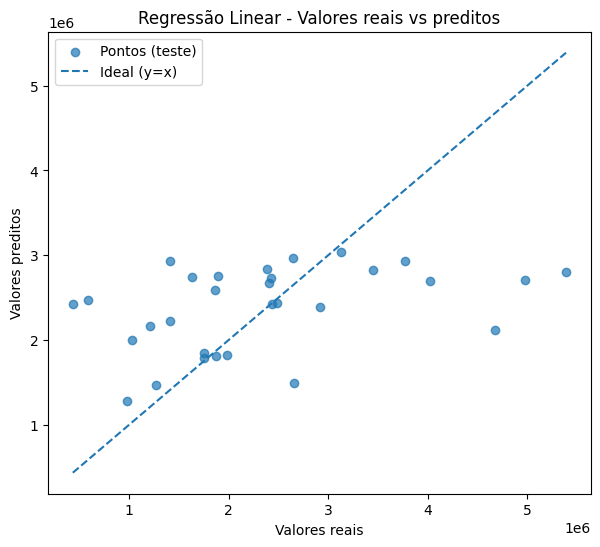

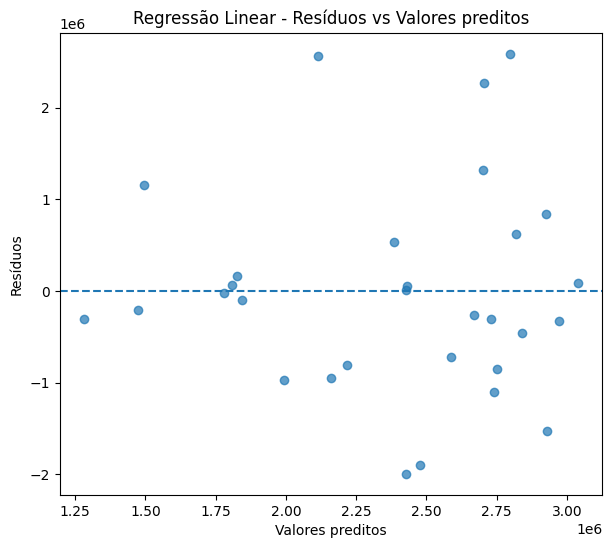

In [9]:
import matplotlib.pyplot as plt

# Predições no teste com colunas selecionadas
X_test_sel = X_test[X_sel.columns]
y_pred_test_sel = model_sel.predict(sm.add_constant(X_test_sel, has_constant='add'))

# --- 1. Gráfico Valores Reais vs Preditos ---
plt.figure(figsize=(7,6))
plt.scatter(y_test, y_pred_test_sel, alpha=0.7, label="Pontos (teste)")
min_v = min(y_test.min(), y_pred_test_sel.min())
max_v = max(y_test.max(), y_pred_test_sel.max())
plt.plot([min_v, max_v], [min_v, max_v], linestyle="--", label="Ideal (y=x)")
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos")
plt.title("Regressão Linear - Valores reais vs preditos")
plt.legend()
plt.show()

# --- 2. Gráfico Resíduos ---
residuos = y_test - y_pred_test_sel
plt.figure(figsize=(7,6))
plt.scatter(y_pred_test_sel, residuos, alpha=0.7)
plt.axhline(0, linestyle="--")
plt.xlabel("Valores preditos")
plt.ylabel("Resíduos")
plt.title("Regressão Linear - Resíduos vs Valores preditos")
plt.show()
